In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import seaborn as sns

import bayesflow as bf
import tensorflow as tf

from functools import partial
from IPython.display import HTML
from bayesflow.simulation import Prior, Simulator, GenerativeModel

### Simulator

In [42]:
def initialize_agents(
        num_agents: int = 12,
        boundary_size: float = 10.0,
        rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    positions = rng.uniform(size=(num_agents, 2)) * boundary_size
    directions = rng.uniform(size=num_agents) * 2 * np.pi

    return positions, directions


def simulator_fun(
    theta: np.ndarray = None,
    num_agents: int = 12,
    num_timesteps: int = 100,
    boundary_size: float = 10.0,
    r_0: float = 5.0,
    rng=None
):
    if rng is None:
        rng = np.random.default_rng()

    if theta is not None:
        radius, speed, eta = theta[0], theta[1], theta[2]
    else:
        radius, speed, eta = 1.0, 1.0, 0.1

    trajectories = np.zeros((num_timesteps + 1, num_agents, 2))
    headings = np.zeros((num_timesteps + 1, num_agents, 1))

    positions, directions = initialize_agents(num_agents, boundary_size, rng)
    trajectories[0] = positions
    headings[0] = directions[:, np.newaxis]

    for t in range(num_timesteps):
        new_directions = np.zeros(num_agents)
        for i in range(num_agents):
            neighbors = []
            for j in range(num_agents):
                if i != j and np.linalg.norm(positions[i] - positions[j]) < radius * r_0:
                    neighbors.append(directions[j])
            if neighbors:
                avg_direction = np.arctan2(np.mean(np.sin(neighbors)), np.mean(np.cos(neighbors)))
                new_directions[i] = avg_direction + rng.uniform(-eta * 0.5, eta * 0.5)
            else:
                new_directions[i] = directions[i]

        directions = new_directions
        
        # Update position upon new direction
        positions[:, 0] += speed * np.cos(directions)
        positions[:, 1] += speed * np.sin(directions)
        
        # Assumes periodic boundary condition
        positions = np.mod(positions, boundary_size)

        trajectories[t + 1] = positions
        headings[t + 1] = directions[:, np.newaxis]

    return np.concatenate((trajectories, headings), axis=-1, dtype=np.float32)

Making sure that it works.

In [57]:
test_path = simulator_fun()
test_path[0,0,:]

array([8.252554 , 0.9970274, 1.7578973], dtype=float32)

In [54]:
def animate(paths, boundary_size = 10.0):
    
    positions = paths[:,:,0:2]
    directions = paths[:,:,2:]
    
    fig, ax = plt.subplots(figsize=(4, 4))


    def update(frame):
        ax.clear()
        quiver = ax.quiver(positions[frame, :, 0], positions[frame, :, 1], np.cos(directions[frame]), np.sin(directions[frame]))
        quiver.set_offsets(positions[frame])
        quiver.set_UVC(np.cos(directions[frame]), np.sin(directions[frame]))
        ax.set_xlim(0, boundary_size)
        ax.set_ylim(0, boundary_size)
        return quiver,

    a = animation.FuncAnimation(fig, update, frames=len(positions), blit=True, repeat=False)
    plt.title("Vicsek Model")
    plt.xlabel("X")
    plt.ylabel("Y")
    
    return a

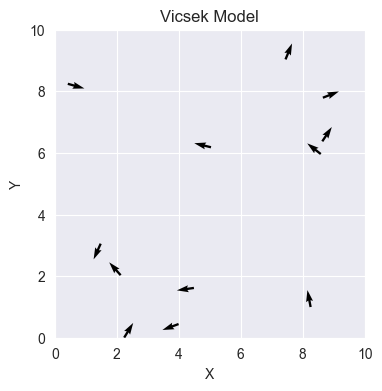

In [58]:
a = animate(test_path)

In [59]:
HTML(a.to_jshtml())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


### Non-hierarchical priors

\begin{align}
    r &\sim \mathrm{Beta}(2, 5),\\
    v &\sim \mathrm{Gamma}(0.5, 1),\\
    \eta &\sim \mathrm{Beta}(5, 5).
\end{align}

In [44]:
def prior_fun(rng=None):
    
    if rng is None:
        rng = np.random.default_rng()
        
    r = rng.beta(2, 5)
    v = rng.gamma(0.5, 1)
    eta = rng.uniform(0, np.pi * 0.25)
    
    return np.array([r, v, eta], dtype=np.float32)

Again, making sure that it works.

In [45]:
test_prior = prior_fun()
test_prior

array([0.16926438, 0.67478335, 0.18195276], dtype=float32)

### Generative Model

In [6]:
param_names = [r'$r$', r'$v$', r'$\eta$']

In [7]:
prior = Prior(prior_fun=prior_fun, param_names=param_names)
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=100000)
prior_means, prior_stds

(array([[0.28521037, 0.5042939 , 0.39234358]], dtype=float32),
 array([[0.15978378, 0.71585226, 0.22749555]], dtype=float32))

In [8]:
simulator = Simulator(simulator_fun=simulator_fun)

In [9]:
model = GenerativeModel(prior=prior, simulator=simulator, simulator_is_batched=False, name="Simple Vicsek")

INFO:root:Performing 2 pilot runs with the Simple Vicsek model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 101, 12, 3)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


### Prior Checks

Prior predictive checks and prior pushforward checks

In [10]:
test_sim = model(10)
test_sim['prior_draws'].astype(float)

array([[0.23486115, 0.38744017, 0.62614095],
       [0.2950744 , 1.61066914, 0.41940182],
       [0.43639809, 0.13984022, 0.51227522],
       [0.12594369, 0.1154794 , 0.04416607],
       [0.36091033, 0.00368793, 0.16030811],
       [0.34065339, 0.7933538 , 0.39465201],
       [0.15727812, 0.00299451, 0.39309204],
       [0.35114112, 0.02364938, 0.13169584],
       [0.41379037, 0.22525363, 0.23738521],
       [0.40403348, 0.03036896, 0.60985363]])

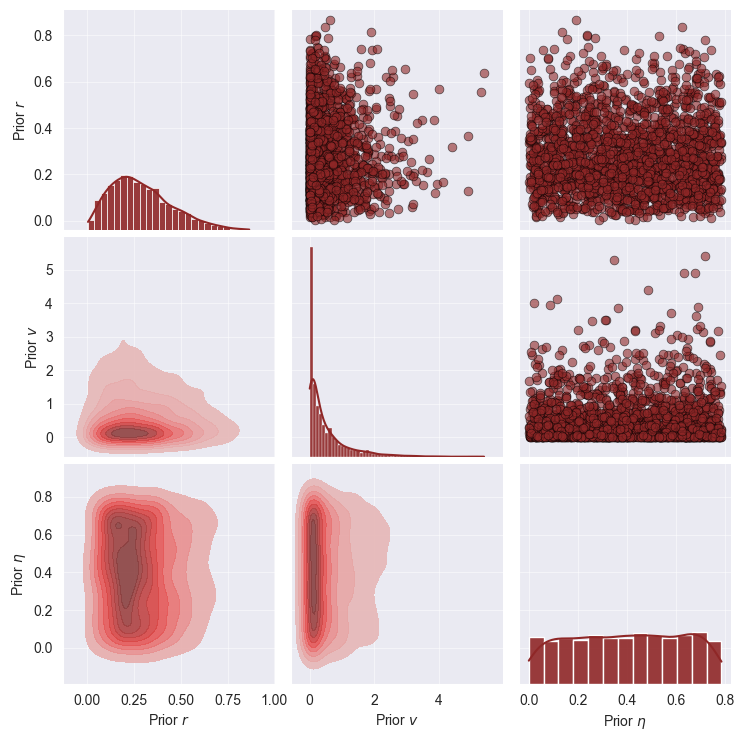

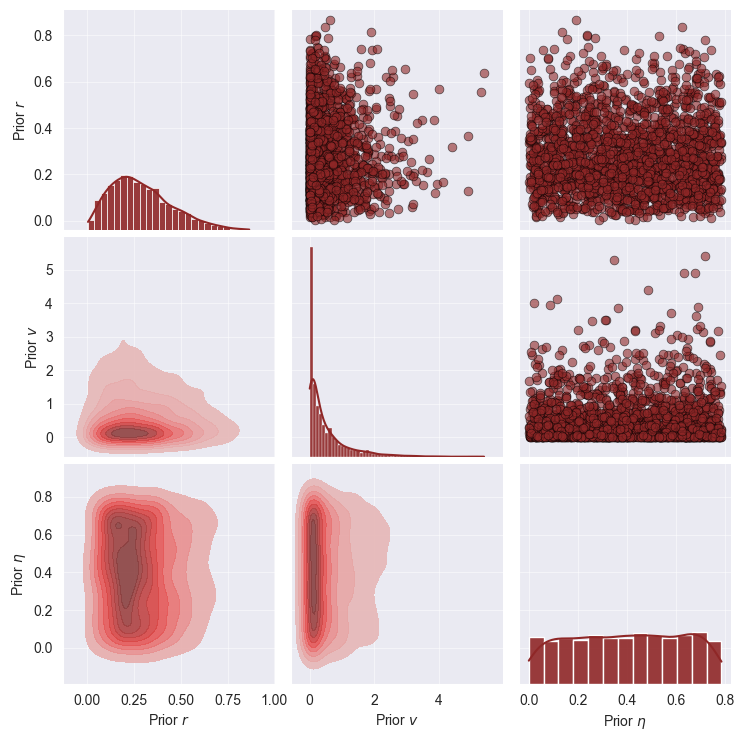

In [46]:
prior.plot_prior2d()

In [11]:
def average_velocity(velocities):
    
    n_timesteps = velocities.shape[0]
    avg = np.zeros(n_timesteps)
    
    for i in range(n_timesteps):
        avg[i] = np.abs(np.sum(velocities[i], axis=-1)) / velocities.shape[1]
        
    return avg

In [12]:
sim_velocities = test_sim['sim_data'][:,:,:,-1]
sim_velocities.shape

(10, 101, 12)

In [13]:
drift = test_sim['prior_draws'][:,1]
drift[2]

0.13984022

In [14]:
avg_velocities = np.zeros((10, 101))
for i in range(sim_velocities.shape[0]):
    avg_velocities[i] = average_velocity(sim_velocities[i])

avg_velocities

array([[3.44363467, 2.13867505, 2.16821384, ..., 0.96784631, 1.008823  ,
        0.89717182],
       [3.7475996 , 1.65967751, 1.61081664, ..., 0.81413881, 0.82155522,
        0.82876388],
       [2.85982227, 1.3118643 , 1.85702833, ..., 2.68692907, 2.67169189,
        2.71382427],
       ...,
       [2.71147823, 0.61341031, 0.61199057, ..., 0.49962775, 0.16662532,
        0.51170103],
       [4.02006086, 1.41565736, 1.39810371, ..., 1.57192008, 1.58920288,
        1.56425651],
       [3.04522387, 1.800855  , 1.88875071, ..., 0.23293098, 0.17935606,
        0.18503873]])

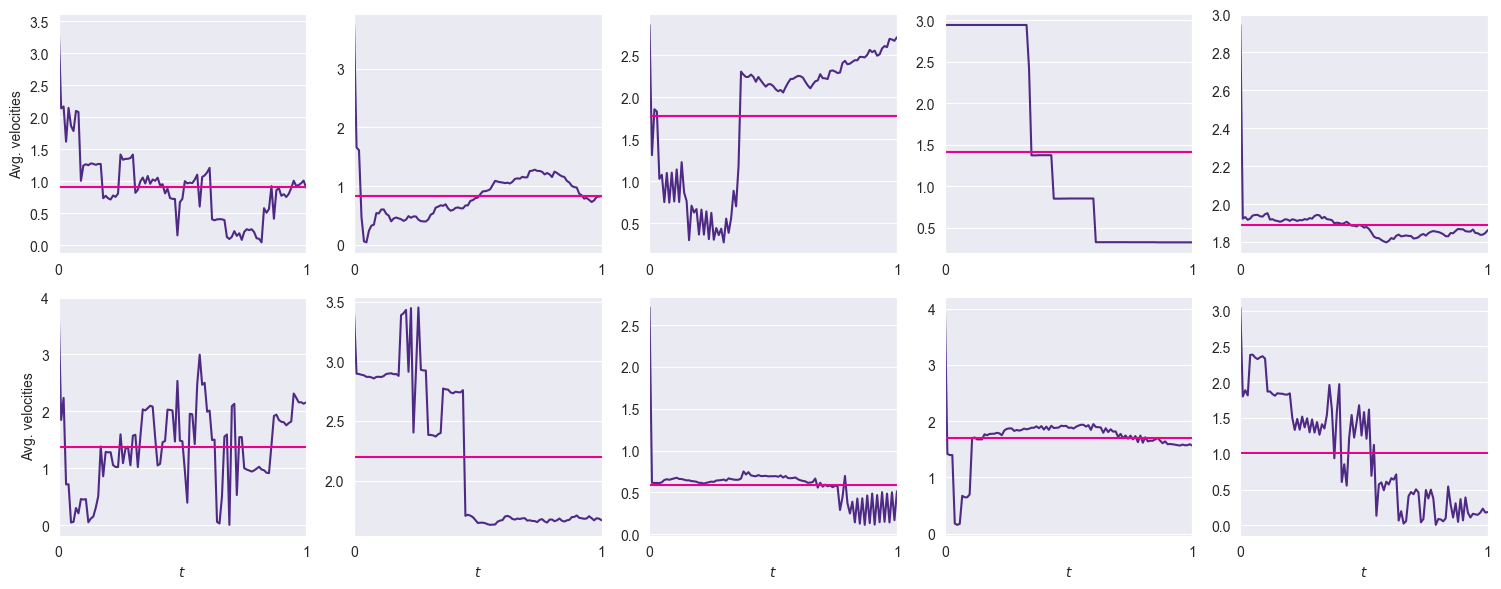

In [15]:
import pandas as pd

f, axarr = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axarr.flat):
    sns.lineplot(x=np.linspace(0., 1., 101), y=avg_velocities[i], sort=False, ax=ax, color="#4e2a84")
    ax.axhline(y=np.mean(avg_velocities[i]),color="#ec008c")
    ax.set(xticks=[0, 1], xlim=[0, 1])
    
    if i > 4:
        ax.set_xlabel(r"$t$")
    if i % 5 == 0:
        ax.set_ylabel("Avg. velocities")
    
f.tight_layout()

In [16]:
test_sim['prior_draws']

array([[0.23486115, 0.38744017, 0.62614095],
       [0.2950744 , 1.6106691 , 0.41940182],
       [0.4363981 , 0.13984022, 0.5122752 ],
       [0.12594369, 0.1154794 , 0.04416607],
       [0.36091033, 0.00368793, 0.16030811],
       [0.3406534 , 0.7933538 , 0.394652  ],
       [0.15727812, 0.00299451, 0.39309204],
       [0.35114112, 0.02364938, 0.13169584],
       [0.41379037, 0.22525363, 0.23738521],
       [0.40403348, 0.03036896, 0.6098536 ]], dtype=float32)

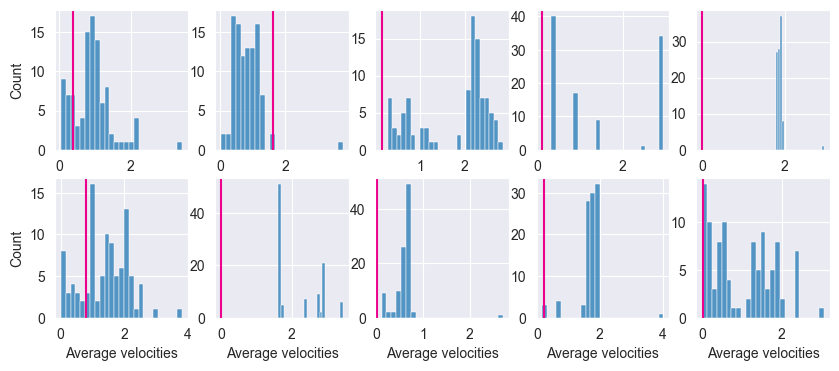

In [17]:
f, axarr = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axarr.flat):
    sns.histplot(avg_velocities[i], bins=25, ax=ax)
    ax.axvline(x=test_sim["prior_draws"][i,1],color="#ec008c")
    
    if i > 4:
        ax.set_xlabel("Average velocities")
    if i % 5 == 0:
        ax.set_ylabel("Count")
    else:
        ax.set_ylabel("")

### Configurator

In [18]:
def configurator(input_dict: dict = None, time_embedding: bool = False):
    output_dict = {}

    theta = input_dict['prior_draws']
    output_dict['parameters'] = theta

    x = input_dict['sim_data'].astype(np.float32)
    
    # Standardizing the data
    x_mean = np.mean(x)
    x_std = np.std(x)
    
    x = (x - x_mean) / x_std
    
    # Standardizing the prior draws
    params = input_dict['prior_draws'].astype(np.float32)
    params_mean = np.mean(params)
    params_std = np.std(params)
    
    params = (params - params_mean) / params_std

    # add time encoding to the data x
    if time_embedding:
        batch_size, num_timesteps, num_agents, _ = x.shape
        time_encoding = np.linspace(0, 1, num_timesteps)
        time_encoding_batched = np.tile(
            time_encoding[np.newaxis, :, np.newaxis, np.newaxis], 
            (batch_size, 1, num_agents, 1)
        )
        
    x1 = np.swapaxes(x, 2, 1)
    

    output_dict['summary_conditions'] = x1
    output_dict['parameters'] = params
    
    return output_dict

In [19]:
# Test a simulation
test_sim = model(100)
test_sim['sim_data']

array([[[[ 5.14355755e+00,  7.12719202e+00,  6.22044230e+00],
         [ 5.05434513e+00,  4.92296219e+00,  6.91095650e-01],
         [ 2.77158475e+00,  3.07041502e+00,  5.12028837e+00],
         ...,
         [ 4.33607769e+00,  6.71379995e+00,  7.80749500e-01],
         [ 6.29860592e+00,  2.54888368e+00,  8.28068733e-01],
         [ 7.97020960e+00,  4.81802130e+00,  2.12692595e+00]],

        [[ 5.14401436e+00,  7.12757683e+00,  7.00265586e-01],
         [ 5.05375051e+00,  4.92302179e+00, -3.24105382e+00],
         [ 2.77164721e+00,  3.06982064e+00, -1.46602416e+00],
         ...,
         [ 4.33667088e+00,  6.71372890e+00, -1.19372800e-01],
         [ 6.29900980e+00,  2.54932380e+00,  8.28068733e-01],
         [ 7.96989393e+00,  4.81852865e+00,  2.12692595e+00]],

        [[ 5.14461184e+00,  7.12757730e+00,  3.77619057e-04],
         [ 5.05418587e+00,  4.92343092e+00,  7.54449069e-01],
         [ 2.77179623e+00,  3.06924200e+00, -1.31891906e+00],
         ...,
         [ 4.33709240e+0

In [20]:
np.min(test_sim['sim_data'])

-3.4735918

In [21]:
out = configurator(test_sim)
out['summary_conditions']

array([[[[ 4.66504872e-01,  1.05594051e+00,  7.86500454e-01],
         [ 4.66640592e-01,  1.05605483e+00, -8.53816330e-01],
         [ 4.66818154e-01,  1.05605495e+00, -1.06178761e+00],
         ...,
         [ 4.80729580e-01,  1.05750668e+00, -8.79505694e-01],
         [ 4.80872989e-01,  1.05740190e+00, -1.24954987e+00],
         [ 4.81017798e-01,  1.05750465e+00, -8.78469646e-01]],

        [[ 4.39995468e-01,  4.00955111e-01, -8.56541216e-01],
         [ 4.39818770e-01,  4.00972813e-01, -2.02497673e+00],
         [ 4.39948142e-01,  4.01094377e-01, -8.37715745e-01],
         ...,
         [ 4.39114988e-01,  3.96307051e-01, -1.17398834e+00],
         [ 4.38939005e-01,  3.96283537e-01, -1.95583832e+00],
         [ 4.39096123e-01,  3.96200776e-01, -1.20590580e+00]],

        [[-2.38325253e-01, -1.49528041e-01,  4.59590435e-01],
         [-2.38306686e-01, -1.49704650e-01, -1.49752784e+00],
         [-2.38262400e-01, -1.49876595e-01, -1.45381570e+00],
         ...,
         [-2.44303375e-0

In [22]:
np.min(out['summary_conditions'])

-2.0940752

In [41]:
out['parameters']

array([[-1.66593995e-02, -9.08511400e-01,  2.44477883e-01],
       [-6.91917658e-01,  1.24508989e+00, -8.24098706e-01],
       [-3.74927849e-01,  2.63081074e+00,  5.53898990e-01],
       [-7.57307768e-01, -8.05799663e-01, -7.32060313e-01],
       [-4.35836941e-01, -8.07804763e-01,  2.54445821e-01],
       [ 1.12448096e-01,  3.46197772e+00, -1.30687371e-01],
       [ 4.47435439e-01, -3.99484545e-01,  1.28173202e-01],
       [-2.77096570e-01, -2.86679715e-01, -1.50829509e-01],
       [-7.45183408e-01, -9.07211065e-01,  9.47863221e-01],
       [-1.69218943e-01, -8.01414073e-01,  2.18686953e-01],
       [ 3.96671854e-02, -6.04996800e-01,  3.46219957e-01],
       [ 1.04353018e-02,  1.71634722e+00,  9.83938873e-01],
       [-3.77511322e-01, -2.88278580e-01,  7.98058659e-02],
       [-4.53852594e-01, -7.83961236e-01, -3.23756427e-01],
       [-5.25613785e-01, -6.73730016e-01,  6.08190596e-01],
       [-3.31299454e-01,  1.56777442e+00,  5.31038046e-01],
       [-4.15386558e-01,  2.67134190e+00

### Neural approximator

In [23]:
# As advised, use SetTransformer in place of DeepSet
summary_net = bf.summary_networks.HierarchicalNetwork([
    tf.keras.layers.TimeDistributed(tf.keras.layers.GRU(units=128)),
    bf.networks.SetTransformer(input_dim=128, summary_dim=64)
])

In [24]:
inference_net = bf.inference_networks.InvertibleNetwork(
    num_params=3, 
    num_coupling_layers=6,
    coupling_settings={
        'kernel_regularizer': tf.keras.regularizers.l2(1e-4),
        'dropout_prob': 0.10
    }
)

In [25]:
amortizer = bf.amortizers.AmortizedPosterior(summary_net=summary_net, inference_net=inference_net)

In [26]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=configurator
)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [27]:
amortizer.summary()

Model: "amortized_posterior"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  605292    
 ibleNetwork)                                                    
                                                                 
 hierarchical_network (Hier  multiple                  468736    
 archicalNetwork)                                                
                                                                 
Total params: 1074028 (4.10 MB)
Trainable params: 1073992 (4.10 MB)
Non-trainable params: 36 (144.00 Byte)
_________________________________________________________________


Simulate data for training

In [28]:
simulation = model(10000)

In [29]:
history = trainer.train_offline(simulation, epochs=100, batch_size=1024, validation_sims=model(500))

Training epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Loss: 3.271


Training epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 2.782


Training epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 2.747


Training epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 2.812


Training epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 2.710


Training epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 2.487


Training epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 2.149


Training epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 1.754


Training epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 1.475


Training epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 1.349


Training epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 1.271


Training epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 1.391


Training epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 0.979


Training epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 1.132


Training epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 0.923


Training epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 1.011


Training epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 0.964


Training epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 0.951


Training epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 0.939


Training epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 0.857


Training epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 0.863


Training epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.762


Training epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.790


Training epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 0.986


Training epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 0.743


Training epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 0.839


Training epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.876


Training epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 0.784


Training epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 0.767


Training epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 0.764


Training epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 0.882


Training epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 0.929


Training epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 0.499


Training epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 0.742


Training epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 0.649


Training epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 0.831


Training epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 0.799


Training epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 0.697


Training epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 0.637


Training epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 0.646


Training epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 0.656


Training epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 0.621


Training epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 0.568


Training epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 0.554


Training epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 0.532


Training epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 0.586


Training epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 0.604


Training epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 0.471


Training epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 0.700


Training epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 0.437


Training epoch 51:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 0.483


Training epoch 52:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 0.876


Training epoch 53:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 0.340


Training epoch 54:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 0.456


Training epoch 55:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 0.562


Training epoch 56:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 0.493


Training epoch 57:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 0.642


Training epoch 58:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 0.501


Training epoch 59:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 0.580


Training epoch 60:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 0.376


Training epoch 61:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 0.447


Training epoch 62:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 0.413


Training epoch 63:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 0.336


Training epoch 64:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 0.391


Training epoch 65:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 0.413


Training epoch 66:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 0.385


Training epoch 67:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 0.402


Training epoch 68:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 0.368


Training epoch 69:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 0.361


Training epoch 70:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 0.367


Training epoch 71:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 0.322


Training epoch 72:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.325


Training epoch 73:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 0.470


Training epoch 74:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.369


Training epoch 75:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 0.386


Training epoch 76:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 0.376


Training epoch 77:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 0.288


Training epoch 78:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 0.265


Training epoch 79:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 0.451


Training epoch 80:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.302


Training epoch 81:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 0.327


Training epoch 82:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 0.350


Training epoch 83:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 0.369


Training epoch 84:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 0.328


Training epoch 85:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 0.373


Training epoch 86:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.401


Training epoch 87:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.363


Training epoch 88:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 0.364


Training epoch 89:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.333


Training epoch 90:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 0.334


Training epoch 91:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 0.357


Training epoch 92:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 0.357


Training epoch 93:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.347


Training epoch 94:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.331


Training epoch 95:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.319


Training epoch 96:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 0.326


Training epoch 97:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 0.327


Training epoch 98:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.330


Training epoch 99:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.331


Training epoch 100:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.331


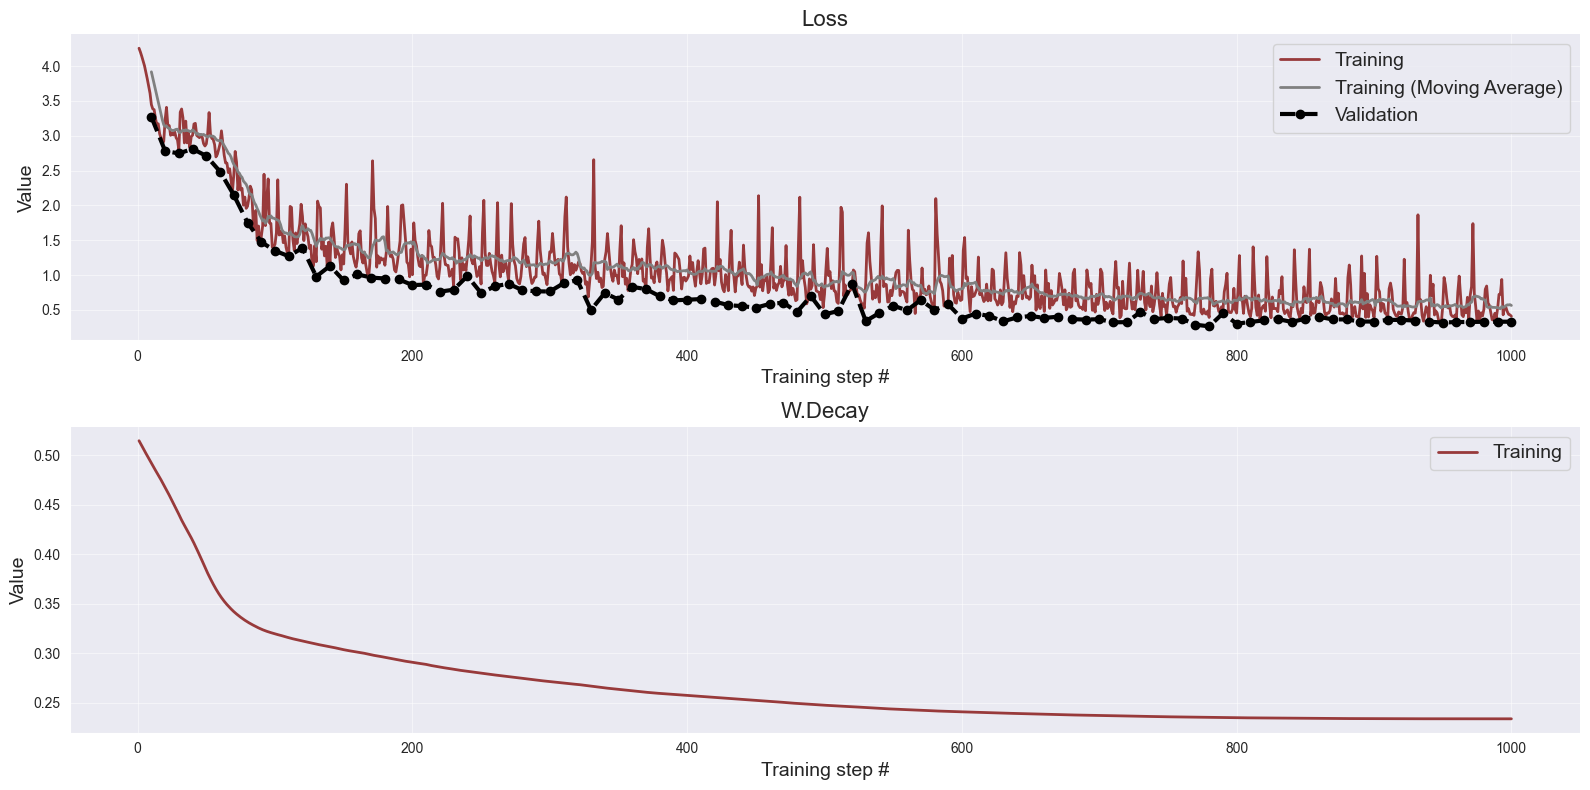

In [30]:
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], moving_average=True)

### Validation

In [31]:
validation_sim = model(500)

In [32]:
validation_sim = configurator(validation_sim)

In [33]:
post_samples = amortizer.sample(validation_sim, n_samples=1000)
post_samples.shape

(500, 1000, 3)

In [34]:
prior_means, prior_stds = prior.estimate_means_and_stds(n_draws=10000)
prior_stds

array([[0.16028239, 0.73208606, 0.22674683]], dtype=float32)

In [35]:
# Prior samples have already been standardized, so the results here are omitted.
prior_samples = validation_sim["parameters"]

Parameter Recovery

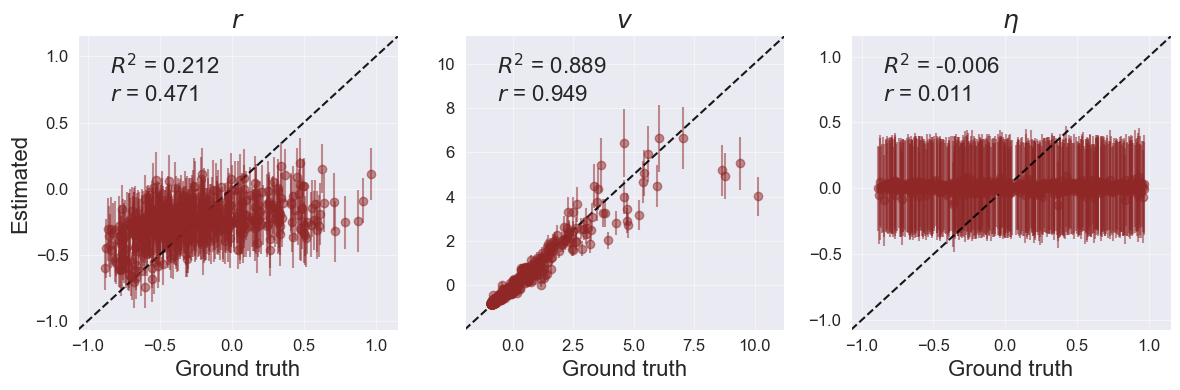

In [36]:
g = bf.diagnostics.plot_recovery(post_samples, prior_samples=prior_samples, param_names=param_names)

Simulation-based calibration

INFO:root:The ratio of simulations / posterior draws should be > 20 for reliable variance reduction, but your ratio is 0.                    Confidence intervals might be unreliable!


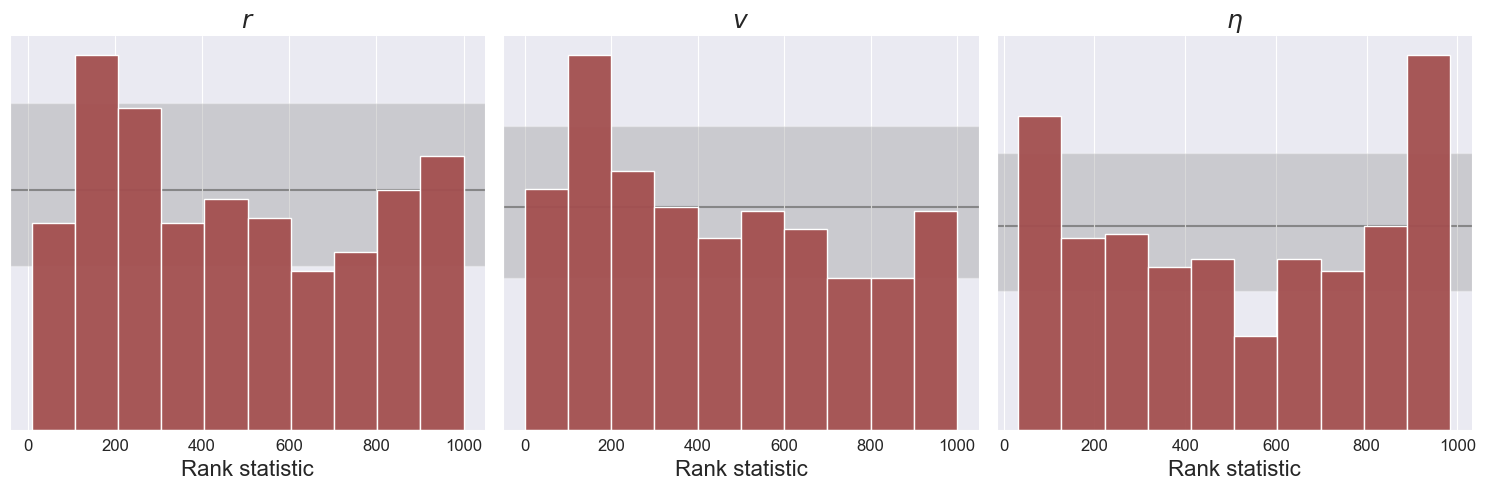

In [37]:
h = bf.diagnostics.plot_sbc_histograms(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names, num_bins=10)

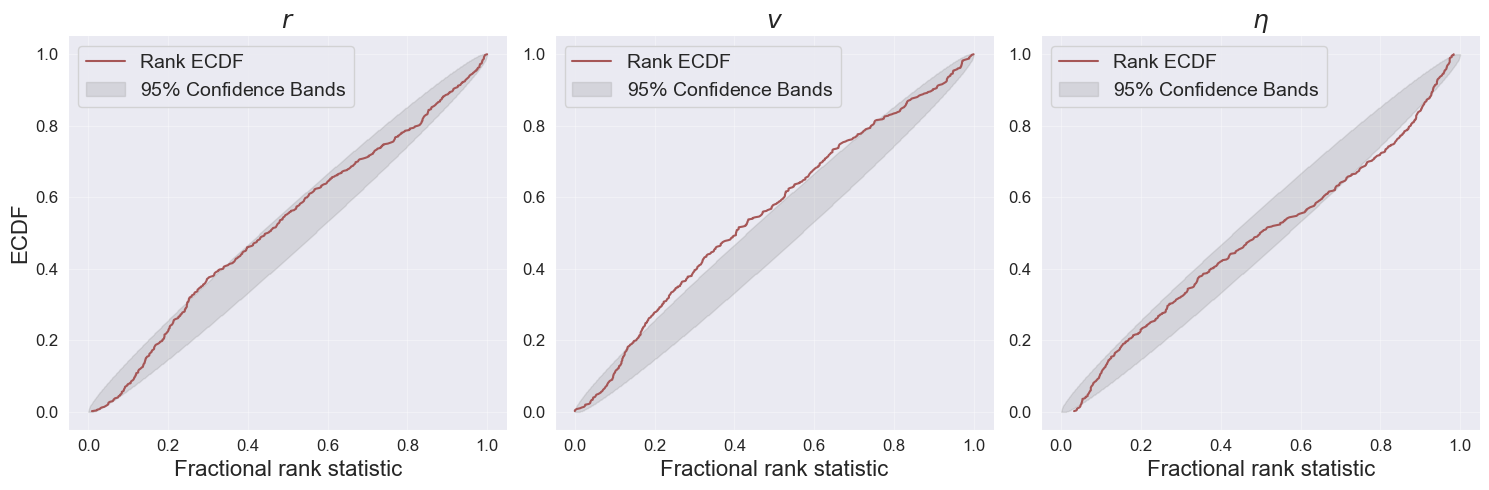

In [38]:
e = bf.diagnostics.plot_sbc_ecdf(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

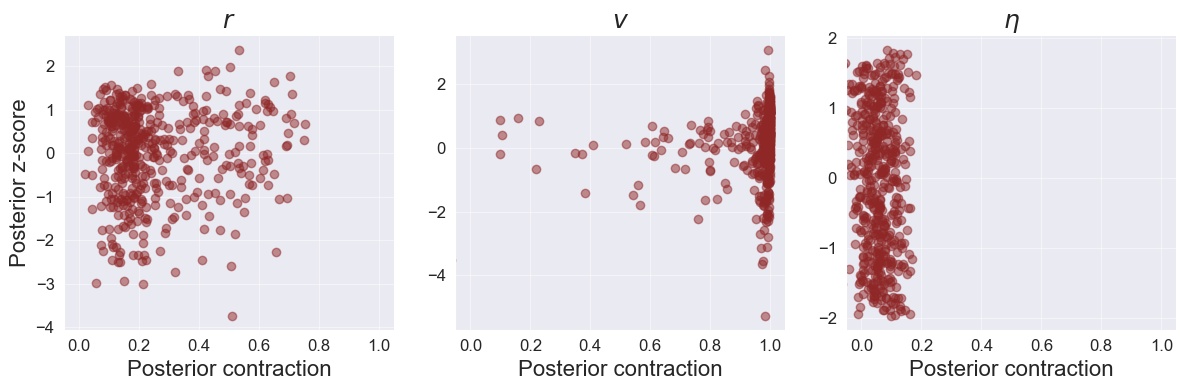

In [39]:
c = bf.diagnostics.plot_z_score_contraction(post_samples=post_samples, prior_samples=prior_samples, param_names=param_names)

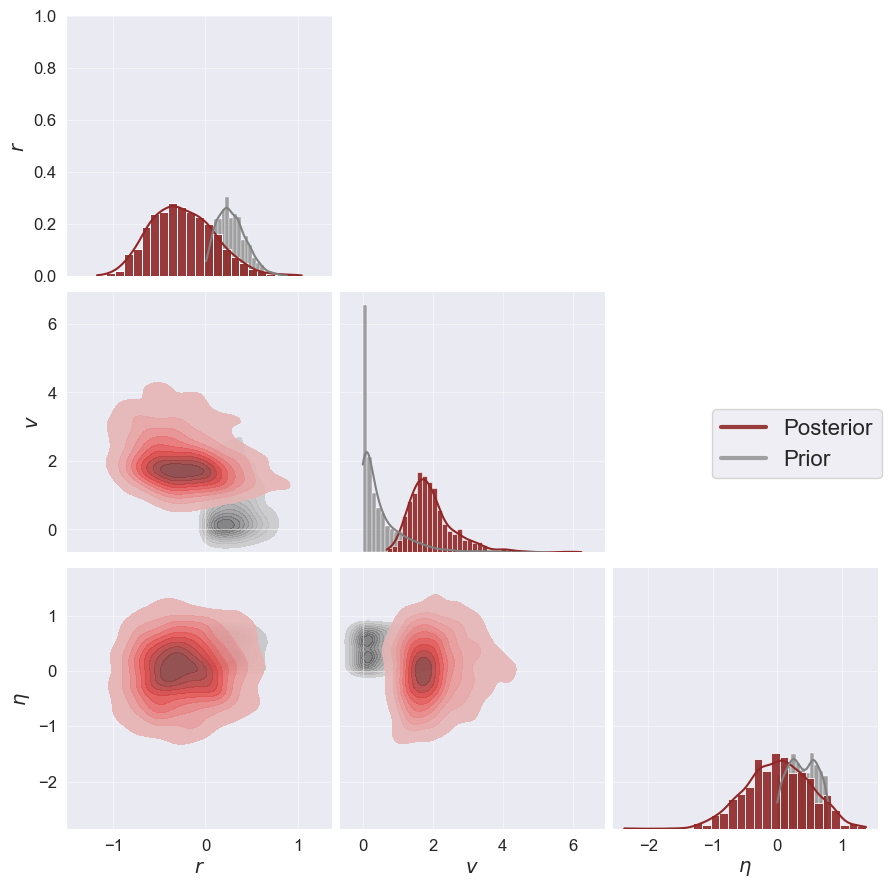

In [40]:
d = bf.diagnostics.plot_posterior_2d(posterior_draws=post_samples[1], prior=prior, param_names=param_names)